<a href="https://colab.research.google.com/github/abel-keya/moringa-school-projects/blob/master/openvino_fastai_pytorch_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install OpenVino

In [0]:
!apt-get update && apt-get upgrade -y &&\
    apt-get autoremove -y
!sudo apt install -y --no-install-recommends \
      build-essential \
      cpio \
      curl \
      git \
      lsb-release \
      pciutils \
      python3.6 \
      python3-pip \
      sudo \
      libusb-1.0-0 libboost-program-options1.62.0 \
      libboost-thread1.62.0 libboost-filesystem1.62.0 \
      libssl1.0.0 libudev1 libjson-c3 usbutils udev wget

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [761 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [80.2 kB]
Hit:13 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB

In [0]:
# uncomment those lines if  you have saved a backup of openvino installer in your drive.
#from google.colab import drive
#drive.mount('/content/gdrive')
#openvino_path = "/content/gdrive/My Drive/fastai_tutoring/data/l_openvino_toolkit_p_2018.5.455.tgz" 

!OV_LINK=http://registrationcenter-download.intel.com/akdlm/irc_nas/15382/l_openvino_toolkit_p_2019.1.094.tgz &&\
 curl $OV_LINK --output l_openvino_toolkit.tgz
openvino_path = "l_openvino_toolkit.tgz"
  
!tar xf "{openvino_path}" &&\
    cd l_openvino_toolkit_p* && \
    ./install_openvino_dependencies.sh &&\
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg  


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 10  860M   10 89.1M    0     0   314k      0  0:46:39  0:04:49  0:41:50  298k^C

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [0]:
!/opt/intel/openvino/deployment_tools/model_optimizer/install_prerequisites/install_prerequisites.sh

/bin/bash: /opt/intel/openvino/deployment_tools/model_optimizer/install_prerequisites/install_prerequisites.sh: No such file or directory


Test openvino on CPU

In [0]:
!source /opt/intel/openvino/bin/setupvars.sh &&\
 /opt/intel/openvino/deployment_tools/demo/demo_squeezenet_download_convert_run.sh 


/bin/bash: /opt/intel/openvino/bin/setupvars.sh: No such file or directory


In [0]:
!source /opt/intel/openvino/bin/setupvars.sh &&\
  python /opt/intel/openvino_2019.1.094/deployment_tools/model_optimizer/mo_caffe.py \
   --input_model /content/MobileNetSSD_deploy.caffemodel --input_proto /content/MobileNetSSD_deploy.prototxt \
   --output_dir ir --data_type FP16

/bin/bash: /opt/intel/openvino/bin/setupvars.sh: No such file or directory


In [0]:
!tar cvzf ir.tgz ir


tar: ir: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [0]:
!find /opt/intel -name mo.py


find: ‘/opt/intel’: No such file or directory


## FastAi to OpenVINO


In [0]:
#install fastai
!curl -s https://course.fast.ai/setup/colab | bash
from fastai.vision import *
from fastai.metrics import error_rate
bs = 64

Updating fastai...
Done.


In [0]:
#create dataset
path = untar_data(URLs.PETS); path
path_img = path/"images"
fnames = get_image_files(path_img)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [0]:
# create a fastai network for transfer learning
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:06<00:00, 13.5MB/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.377336,0.326398,0.108931,01:24
1,0.621452,0.270209,0.091340,01:21
2,0.388800,0.225546,0.073748,01:21
3,0.270188,0.221216,0.070365,01:19


In [0]:
# save model to Onnx format
import torch
import torchvision

dummy_input = torch.randn(1, 3, 224, 224, device='cuda')
onnx_path =  "/content/model_fastai.onnx"

torch.onnx.export(learn.model, dummy_input, onnx_path, verbose=False)
print('Model exported to ' + onnx_path)

from fastai import basic_train
#retrieve the activation function used to reproduce the same actiavtion after
# network ouput
print(basic_train._loss_func2activ(learn.loss_func))

#create labels file
with open("pets.classes", 'w') as dc:
  dc.write('\n'.join(data.classes))
  
# export the stats to normalize the image
with open('/content/norm.txt', 'w') as fd:
  fd.write(repr(imagenet_stats)) 

Model exported to /content/model_fastai.onnx
functools.partial(<function softmax at 0x7f6e445f3b70>, dim=-1)


# Testing the inference with fast.ai

In [0]:
images_path = get_image_files(path_img, recurse=True)[0:4]
images_path

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_10.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_172.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_38.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_27.jpg')]

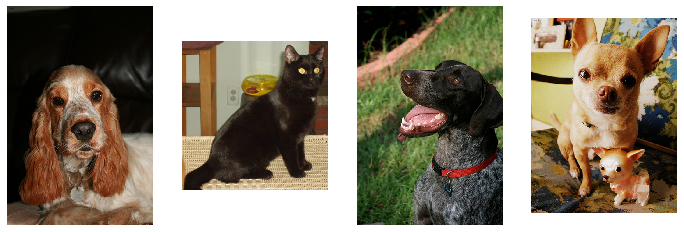

In [0]:
images = [open_image(i) for i in images_path]
show_all(images)

In [0]:
for i, im in enumerate(images):
  p = learn.predict(im)
  print(images_path[i], p[0], p[2][p[1]].item())

/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_10.jpg english_cocker_spaniel 0.9997972846031189
/root/.fastai/data/oxford-iiit-pet/images/Bombay_172.jpg Bombay 0.9999852180480957
/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_38.jpg german_shorthaired 0.9999730587005615
/root/.fastai/data/oxford-iiit-pet/images/chihuahua_27.jpg chihuahua 0.9996470212936401


# Inference with OpenVino on CPU

In [0]:
# create the Intermediate Representation and run inference on the CPU
!source /opt/intel/openvino/bin/setupvars.sh &&\
python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
   --input_model model_fastai.onnx --output_dir ir --data_type FP32

/bin/bash: /opt/intel/openvino/bin/setupvars.sh: No such file or directory


In [0]:
!cat ./norm.txt

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [0]:
# generated a python file (to be able to run it as a script with OpenVINO environment
s = r"""
import sys
import os
from argparse import ArgumentParser
import cv2
import numpy as np
import logging as log
from time import time
from openvino.inference_engine import IENetwork, IEPlugin
import math

# here put the values from the norm.txt file

resnet_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
resnet_scale = np.array([0.229, 0.224, 0.225], dtype=np.float32)


def preprocess(im, h, w):
    assert(h == w == 224)
    sz = 224
    # convert image to [0-1] RGB, Width Height Channel
    im = im.astype(np.float32) / 255
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # resize and crop center
    r,c, *_ = im.shape
    ratio = sz / min(r, c)
    im = cv2.resize(im, 
                    (max(math.floor(c * ratio), sz), max(math.floor(r * ratio), sz)),
                    interpolation=cv2.INTER_AREA)
    startx = math.ceil((im.shape[0] - sz) / 2)
    starty = math.ceil((im.shape[1] - sz) / 2)
    im = im[startx:startx + sz, starty:starty + sz]

    # normalize and convert to Channel Width Height
    im = (im - resnet_mean) / resnet_scale
    im = im.transpose((2, 0, 1))
    return im


parser = ArgumentParser()
parser.add_argument("-m", "--model", help="Path to an .xml file with a trained model.", required=True, type=str)
parser.add_argument("-i", "--input", help="Path to a folder with images or path to an image files", required=True,
                    type=str, nargs="+")
parser.add_argument("-d", "--device",
                    help="Specify the target device to infer on; CPU, GPU, FPGA or MYRIAD is acceptable. Sample "
                         "will look for a suitable plugin for device specified (CPU by default)", default="CPU",
                    type=str)
parser.add_argument("--labels", help="Labels mapping file", default=None, type=str)
parser.add_argument("-nt", "--number_top", help="Number of top results", default=10, type=int)


log.basicConfig(format="[ %(levelname)s ] %(message)s", level=log.INFO, stream=sys.stdout)
args = parser.parse_args()
model_xml = args.model
model_bin = os.path.splitext(model_xml)[0] + ".bin"

# Plugin initialization for specified device and load extensions library if specified
plugin = IEPlugin(device=args.device)
# Read IR
log.info("Loading network files:\n\t{}\n\t{}".format(model_xml, model_bin))
net = IENetwork(model=model_xml, weights=model_bin)

assert len(net.inputs.keys()) == 1, "Sample supports only single input topologies"
assert len(net.outputs) == 1, "Sample supports only single output topologies"

log.info("Preparing input blobs")
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))
net.batch_size = len(args.input)

# Read and pre-process input images
n, c, h, w = net.inputs[input_blob].shape
images = np.ndarray(shape=(n, c, h, w))
for i in range(n):
    image = cv2.imread(args.input[i])
    image = preprocess(image, h, w)
    images[i] = image

log.info("Loading model to the plugin")
exec_net = plugin.load(network=net)
del net

log.info("Starting inference)")
res = exec_net.infer(inputs={input_blob: images})

log.info("Processing output blob")
res = res[out_blob]
log.info("Top {} results: ".format(args.number_top))
if args.labels:
    with open(args.labels, 'r') as f:
        labels_map = [x.split(sep=' ', maxsplit=1)[-1].strip() for x in f]
else:
    labels_map = None
for i, probs in enumerate(res):
    probs = np.squeeze(probs)
    
    #### add the softmax layer manually
    probs = np.exp(probs)/sum(np.exp(probs))
    ####
    
    top_ind = np.argsort(probs)[-args.number_top:][::-1]
    print("Image {}".format(args.input[i]))
    for id in top_ind:
        det_label = labels_map[id] if labels_map else "#{}".format(id)
        print("{:.7f} label {}".format(probs[id], det_label))
    print("")

del exec_net
del plugin
"""
with open("infer.py", 'w') as pf:
  pf.write(s)

!source /opt/intel/openvino/bin/setupvars.sh &&\
 python3 infer.py -d CPU -m ir/model_fastai.xml \
  --labels pets.classes \
  -nt 1 -i {images_path[0]} {images_path[1]} {images_path[2]} {images_path[3]}

/bin/bash: /opt/intel/openvino/bin/setupvars.sh: No such file or directory


## With Pytorch model - TBD

In [0]:
# export the model from Pytorch
import torch
from torch import nn
import torchvision

onnx_path =  "/content/model_pytorch.onnx"

dummy_input = torch.randn(10, 3, 224, 224, device='cuda')
model = torchvision.models.resnet50(pretrained=True).cuda()
model= nn.Sequential(*list(model.children())[:-2])

torch.onnx.export(model, dummy_input, onnx_path, verbose=False)
print('Model exported to ' + onnx_path)

   

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:29<00:00, 3.49MB/s]


Model exported to /content/model_pytorch.onnx


## Export model to Gdrive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


In [0]:
#save the models to google Drive for easy sharing and downloading
!tar cvzf models_float_exception.tgz model_fastai.onnx model_pytorch.onnx irb
!cp models_float_exception.tgz gdrive/My\ Drive/fastai_tutoring/data

In [0]:
# create the Intermediate Representation and run inference
!source /opt/intel/openvino/bin/setupvars.sh &&\
python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
   --input_model model_pytorch.onnx --output_dir ir --data_type FP32
      
!source /opt/intel/openvino/bin/setupvars.sh &&\
python3 /opt/intel/openvino/deployment_tools/inference_engine/samples/python_samples/classification_sample/classification_sample.py \
  -d CPU -m ir/model_pytorch.xml \
  --labels dummy.classes \
  -nt 1 -i /opt/intel/openvino/deployment_tools/demo/car.png ;\
echo "Error code $?"

## Show the models

In [0]:
learn.model

In [0]:
model
